In [1]:
!pip install numba

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from  numba import jit

In [3]:
#Enter the sum of digits in your enrollment number as seed
def environment(seed, customers):
  np.random.seed(seed)
  conversion_rates = np.random.uniform(0,0.2,9)
  X = np.array(np.zeros([customers,9]))
  for i in range(customers):
    for j in range(9):
      if random.random() <= conversion_rates[j]:
        X[i,j] = 1
  return X

seed = 15
customers = 10000
Reward_matrix = environment(seed, customers)
print(Reward_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
np.random.seed(seed)
conversion_rates = np.random.uniform(0,0.2,9)
pstar = max(conversion_rates)
conversion_rates

array([0.16976354, 0.03577918, 0.01087264, 0.07230769, 0.05508019,
       0.10600004, 0.06118378, 0.06089487, 0.02234826])

**For each new customer that comes online on the website we predict an arm based on the previous history of arms being pulled and whatever arm is pulled we will check whether the customer subscribes to premium (based on the *Reward_matrix*) or not which will be our reward (subscription being a success otherwise failure).**

# Thompson sampling


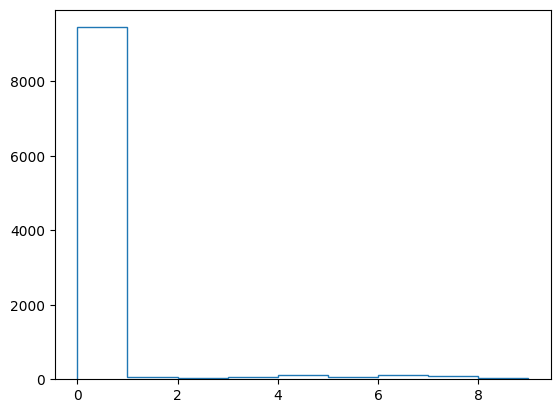

In [ ]:
s = np.zeros(9)
f = np.zeros(9)

for i in range(customers):
  maxim = -1
  index = -1
  for j in range(9):
    temp = random.betavariate(s[j]+1, f[j]+1)
    if temp > maxim:
      maxim = temp
      index = j
  if Reward_matrix[i][index] == 1:
    s[index] = s[index] + 1
  else:
    f[index] = f[index] + 1

u = s + f
arms=[1,2,3,4,5,6,7,8,9]
plt.stairs(u)

#UCB Algorithm



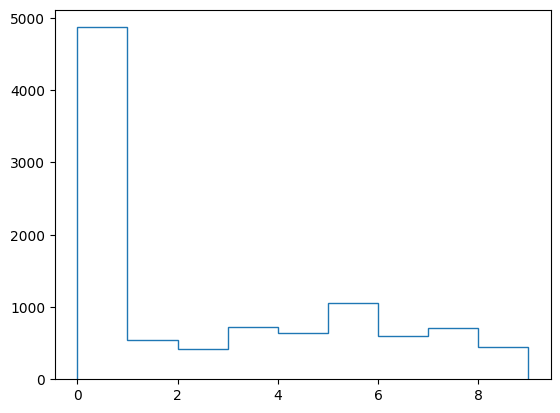

In [ ]:
#UCB
sus = np.zeros(9)
pulls = np.zeros(9)
ucb = np.zeros(9)
for i in range(customers):

  sol = []
  for j in range(9):
    if pulls[j] == 0:
      sol.append(j)
      ucb[j]= 2
    else:
      ucb[j] = (sus[j]/pulls[j]) + math.sqrt(2*math.log(i)/pulls[j])
  for j in range(9):
    if ucb[j]==max(ucb):
      sol.append(j)
  pick = np.random.choice(sol)
  pulls[pick] = pulls[pick] + 1
  if Reward_matrix[i][pick]==1:
    sus[pick] = sus[pick] + 1


plt.stairs(pulls);



# UCB - KL

In [7]:
@jit(nopython=True)
def KL(x,y):
  val = x*np.log(x/y) + (1-x)*np.log((1-x)/(1-y))
  return val

@jit(nopython=True)
def findqo(p, u, t,maxima,a):
  q = p + (maxima-p)/2
  #print(q)
  x = (np.log(t) + 3*np.log(np.log(t))) / u
  #print (x,KL(a,q))
  if (a==q or q==maxima):
    return q
  elif(abs(x-KL(a,q))<0.0004):
    return q
  elif(x<KL(a,q)):
    return findqo(p,u,t,q,a)
  else:
    return findqo(q,u,t,maxima,a)

@jit(nopython=True)
def findQ(p,u,t,maxima):
  a = p
  return findqo(p,u,t,maxima,a)

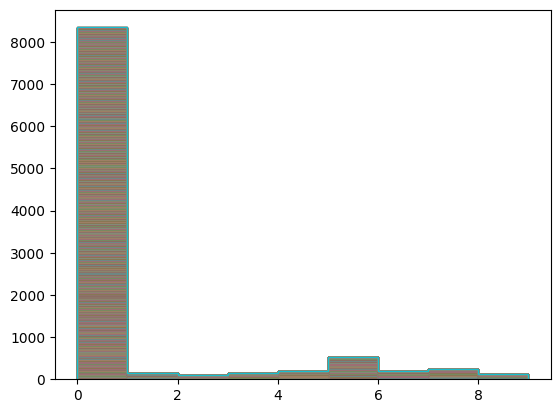

In [ ]:
sus = np.zeros(9)
pulls = np.zeros(9)
ucbkl = np.zeros(9)
for i in range(customers):
  sol = []
  for j in range(9):
    if pulls[j] == 0:
      sol.append(j)
      ucbkl[j]= 2
    else:
      ucbkl[j] = findQ(sus[j]/pulls[j],pulls[j],i,1)
  for j in range(9):
    if ucbkl[j]==max(ucbkl):
      sol.append(j)
  pick = np.random.choice(sol)
  pulls[pick] = pulls[pick] + 1
  if Reward_matrix[i][pick]==1:
    sus[pick] = sus[pick] + 1

  plt.stairs(pulls)

In [ ]:
ucb = np.ones(9)
pulls = np.ones(9)
sus = [9,2,3,4,4,3,5,6,4]
ind = [1,3,8]
for index in ind:
  sus[index] = 24
sus

[9, 24, 3, 24, 4, 3, 5, 6, 24]

In [ ]:
np.random.beta(100,100)

0.5601804250409361

#Que c

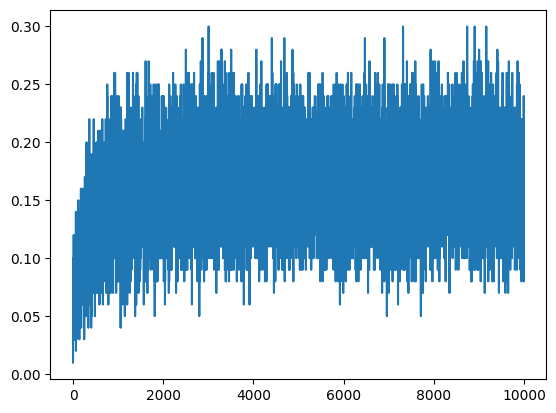

In [5]:
reg_thom = np.linspace(1,customers,customers)
wins = np.zeros(customers)

for l in range(100):
  Reward_matrix = environment(seed,customers)
  s = np.zeros(9)
  f = np.zeros(9)
  for i in range(customers):
    maxim = -1
    index = -1
    for j in range(9):
      temp = random.betavariate(s[j]+1, f[j]+1)
      if temp > maxim:
        maxim = temp
        index = j
    if Reward_matrix[i][index] == 1:
      s[index] = s[index] + 1
      wins[i] = wins[i] + 1
    else:
      f[index] = f[index] + 1


reg_thom = reg_thom*pstar
wins = wins/100
plt.plot(wins);
for i in range(customers-1):
  wins[i+1] = wins[i] + wins[i+1]

reg_thom = reg_thom - wins


In [ ]:
s

array([1530.,    0.,    2.,    7.,    0.,   23.,    7.,    6.,    0.])

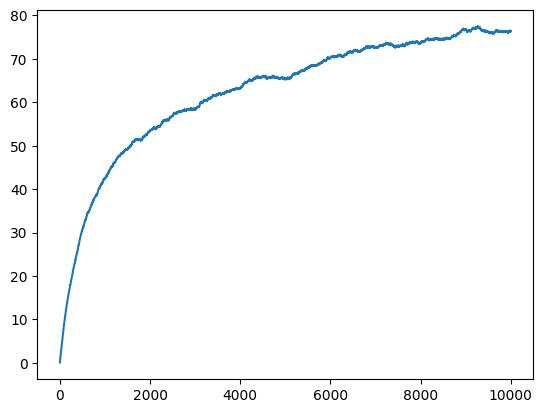

In [ ]:
plt.plot(reg_thom )

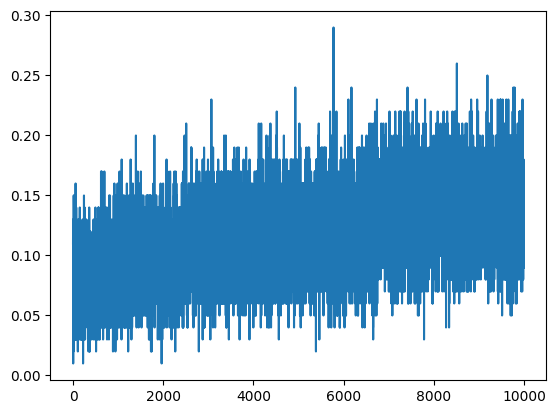

In [6]:
rucb = np.linspace(1,customers,customers)
wins =np.zeros(customers)
for l in range(100):

  sus = np.zeros(9)
  pulls = np.zeros(9)
  ucb = np.zeros(9)
  Reward_matrix = environment(seed,customers)

  for i in range(customers):

    sol = []
    for j in range(9):
      if pulls[j] == 0:
        sol.append(j)
        ucb[j]= 2
      else:
        ucb[j] = (sus[j]/pulls[j]) + math.sqrt(2*math.log(i)/pulls[j])
    for j in range(9):
      if ucb[j]==max(ucb):
        sol.append(j)
    pick = np.random.choice(sol)
    pulls[pick] = pulls[pick] + 1
    if Reward_matrix[i][pick]==1:
      sus[pick] = sus[pick] + 1
      wins[i]= wins[i] + 1


rucb = rucb*pstar
wins = wins/100
plt.plot(wins);
for i in range(customers-1):
  wins[i+1] = wins[i] + wins[i+1]

rucb = rucb - wins



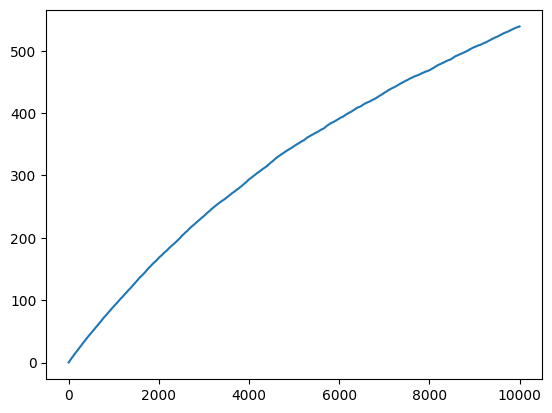

In [ ]:
plt.plot(rucb);

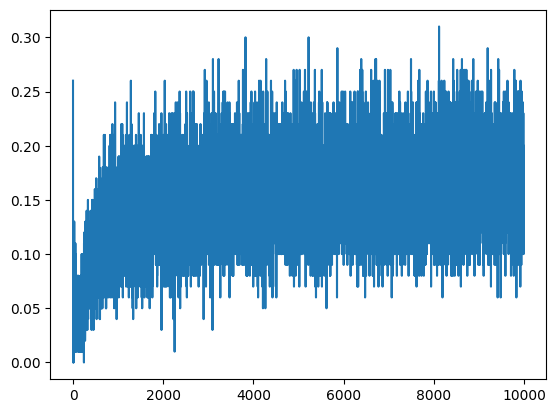

In [8]:
rucbkl = np.linspace(1,customers,customers)
wins =np.zeros(customers)

for l in range(100):

  sus = np.zeros(9)
  pulls = np.zeros(9)
  ucbkl = np.zeros(9)
  Reward_matrix = environment(seed, customers)
  for i in range(customers):
    sol = []
    for j in range(9):
      if pulls[j] == 0:
        sol.append(j)
        ucbkl[j]= 2
      else:
        ucbkl[j] = findQ(sus[j]/pulls[j],pulls[j],i,1)
    for j in range(9):
      if ucbkl[j]==max(ucbkl):
        sol.append(j)
    pick = np.random.choice(sol)
    pulls[pick] = pulls[pick] + 1
    if Reward_matrix[i][pick]==1:
      sus[pick] = sus[pick] + 1
      wins[i] = wins[i] + 1

rucbkl = rucbkl*pstar
wins = wins/100
plt.plot(wins);
for i in range(customers-1):
  wins[i+1] = wins[i] + wins[i+1]

rucbkl = rucbkl - wins


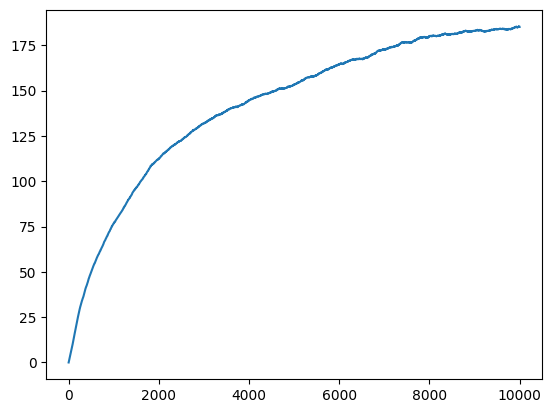

In [ ]:
plt.plot(rucbkl)

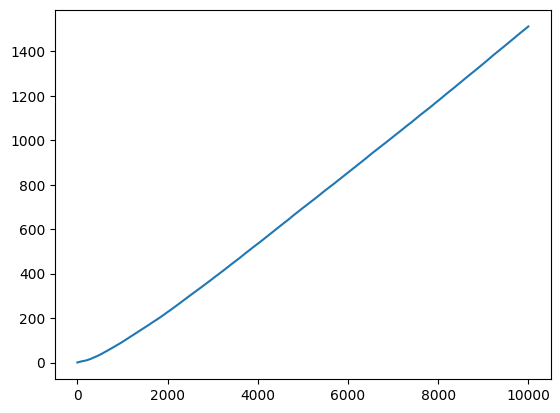

In [ ]:
plt.plot(wins)

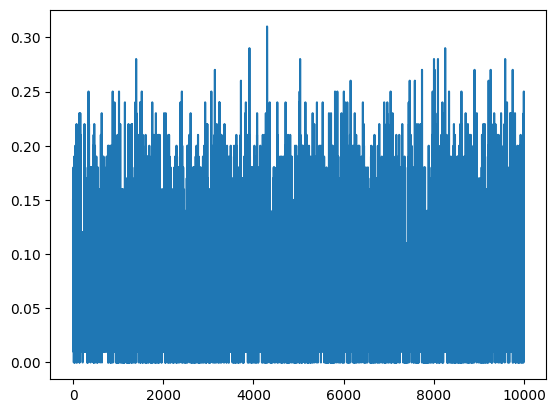

In [9]:
rrand = np.linspace(1,customers,customers)
wins = np.zeros(customers)
arms = [0,1,2,3,4,5,6,7,8]

for l in range(100):

  Reward_matrix = environment(seed,customers)
  for i in range(customers):

    pick = np.random.choice(arms)
    if Reward_matrix[i][pick]==1:
      wins[i] = wins[i] + 1

rrand = rrand*pstar
wins = wins/100
plt.plot(wins);
for i in range(customers-1):
  wins[i+1] = wins[i] + wins[i+1]

rrand = rrand - wins





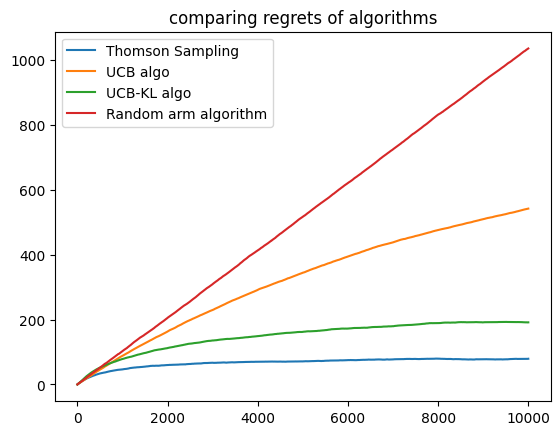

In [11]:
plt.plot(reg_thom,label = 'Thomson Sampling')
plt.plot(rucb, label = "UCB algo")
plt.plot(rucbkl,label = "UCB-KL algo")
plt.plot(rrand,label="Random arm algorithm")
plt.legend()
plt.title("comparing regrets of algorithms");